# 🗒️ Proyecto NLP + Deep Learning con Comentarios del New York Times

## 📌 Introducción

En este notebook trabajaremos con el dataset de comentarios de los artículos del **New York Times**, que recoge más de 2 millones de comentarios publicados entre enero–mayo de 2017 y enero–abril de 2018. Cada comentario viene acompañado de información contextual (sección del artículo, número de recomendaciones, selección de editores, etc.), lo que nos permitirá explorar tanto el contenido textual como los metadatos asociados.

Dividiremos el análisis en dos fases:

1. **NLP básico**: tareas de preprocesamiento de texto  
2. **Deep Learning sencillo**: construcción y entrenamiento de una red neuronal para una tarea de predicción sobre los comentarios

## 🎯 Objetivos

- **Preprocesamiento de texto**  
  - Tokenización  
  - Eliminación de stopwords  
  - (Opcional) Lemmatización o stemming y limpieza de puntuación/caracteres especiales  

- **Vectorización**  
  - Transformar los comentarios en representaciones numéricas con `CountVectorizer` o `TfidfVectorizer`  

- **Red neuronal sencilla**  
  - Definir un modelo en Keras/TensorFlow (por ejemplo una o dos capas Dense o una pequeña LSTM)  
  - Entrenar la red para una tarea concreta, como predecir si un comentario será seleccionado por editores (`editorsSelection`) o la cantidad de recomendaciones (`recommendations`)  

- **Análisis y visualización**  
  - Graficar distribuciones de longitud de comentario y popularidad  
  - Mostrar las palabras y bigramas más frecuentes  

- **Extensión para la Entrega Final**  
  - Profundizar en NLP: análisis de sentimiento avanzado, modelado de temas, visualizaciones interactivas  
  - O mejorar la red: añadir capas, regularización, búsqueda de hiperparámetros, integrar embeddings preentrenados  

## 🔗 Dataset

- Comentarios:  
  - Más de 2 millones de filas, 34 columnas (texto, autor, fecha, sección, recomendaciones, editoresSelection, replyCount, etc.)  
- Artículos:  
  - ~9 000 artículos con 16 columnas de metadatos (título, sección, fecha, URL, etc.)  

Descarga directa en Kaggle:  
[NYT Comments Dataset](https://www.kaggle.com/datasets/aashita/nyt-comments)

## 🧰 Librerías necesarias

```python
import pandas as pd
import numpy as np
import nltk
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [66]:
# Descargar y descomprimir el dataset de Kaggle
import os
import kagglehub

# Análisis y manipulación de datos
import glob
import pandas as pd
import numpy as np

# NLP y vectorización
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy

# Descargar recursos de NLTK
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

# Deep Learning con TensorFlow y Keras
import tensorflow as tf
from tensorflow.keras import layers, models

# Visualización
import matplotlib.pyplot as plt
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\George\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\George\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\George\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\George\AppData\Roaming\nltk_data...


## 🔍 EDA: Analisis Inicial del Dataset

### 🗃️ Carga de Datos

El primer paso será cargar los datos desde Kaggle al notebook y determinar el path al archivo. Este dataset está compuesto por 18 archivos, los cuales poseen artículo y comentarios del diario New York Times en diferentes meses de los años 2017 y 2018.

Los artículos están conglomerados en 9 archivos CSV. Cada archivo posee un link a cada artículo, con su autor, un resumen y otros datos de interés.

| Archivo               | Año / Mes |
| --------------------- | --------- |
| ArticlesJan2017.csv   | Ene 2017  |
| ArticlesFeb2017.csv   | Feb 2017  |
| ArticlesMarch2017.csv | Mar 2017  |
| ArticlesApril2017.csv | Abr 2017  |
| ArticlesMay2017.csv   | May 2017  |
| ArticlesJan2018.csv   | Ene 2018  |
| ArticlesFeb2018.csv   | Feb 2018  |
| ArticlesMarch2018.csv | Mar 2018  |
| ArticlesApril2018.csv | Abr 2018  |

En el caso de los comentarios, los mismos están también han sido agrupados por mes, pero además de incluir los datos correspondientes a cada comentario (autor, cuerpo del comentario, título, resumen) también poseen información respecto a sobre cuál articulo fueron originalmente posteados.

| Archivo               | Año / Mes |
| --------------------- | --------- |
| CommentsJan2017.csv   | Ene 2017  |
| CommentsFeb2017.csv   | Feb 2017  |
| CommentsMarch2017.csv | Mar 2017  |
| CommentsApril2017.csv | Abr 2017  |
| CommentsMay2017.csv   | May 2017  |
| CommentsJan2018.csv   | Ene 2018  |
| CommentsFeb2018.csv   | Feb 2018  |
| CommentsMarch2018.csv | Mar 2018  |
| CommentsApril2018.csv | Abr 2018  |

In [47]:
# Descargar la última versión del dataset
path = kagglehub.dataset_download("aashita/nyt-comments")

print("Archivos descargados en:", path)

Archivos descargados en: C:\Users\George\.cache\kagglehub\datasets\aashita\nyt-comments\versions\13


En este notebook solo nos interesan los comentarios, no los artículos, por lo que procederemos a extraer los mismos desde el dataset y determinar cuales son los atributos presentes en cada archivos CSV. El objetivo es determinar aquellos atributos que necesitamos para poder crear una red neuronal capaz de determinar el sentimiento de un comentario.

In [54]:
# Buscar solo archivos de comentarios
comment_files = sorted([f for f in glob.glob(os.path.join(path, "*.csv")) if "Comments" in os.path.basename(f)])

# Lista para guardar los DataFrames
comment_dfs = []

# Cargar y guardar información de columnas
for file in comment_files:
    try:
        df = pd.read_csv(file, low_memory=False)
        comment_dfs.append(df)
        print(f"{os.path.basename(file)} → {list(df.columns)}")
    except Exception as e:
        print(f"Error al leer {file}: {e}")

CommentsApril2017.csv → ['approveDate', 'commentBody', 'commentID', 'commentSequence', 'commentTitle', 'commentType', 'createDate', 'depth', 'editorsSelection', 'parentID', 'parentUserDisplayName', 'permID', 'picURL', 'recommendations', 'recommendedFlag', 'replyCount', 'reportAbuseFlag', 'sharing', 'status', 'timespeople', 'trusted', 'updateDate', 'userDisplayName', 'userID', 'userLocation', 'userTitle', 'userURL', 'inReplyTo', 'articleID', 'sectionName', 'newDesk', 'articleWordCount', 'printPage', 'typeOfMaterial']
CommentsApril2018.csv → ['approveDate', 'articleID', 'articleWordCount', 'commentBody', 'commentID', 'commentSequence', 'commentTitle', 'commentType', 'createDate', 'depth', 'editorsSelection', 'inReplyTo', 'newDesk', 'parentID', 'parentUserDisplayName', 'permID', 'picURL', 'printPage', 'recommendations', 'recommendedFlag', 'replyCount', 'reportAbuseFlag', 'sectionName', 'sharing', 'status', 'timespeople', 'trusted', 'typeOfMaterial', 'updateDate', 'userDisplayName', 'userI

### ✂️ Filtrado de Atributos

Como se puede observar, cada CSV posee una gran cantidad de atributos. Nosotros solo necesitamos el cuerpo de cada comentario. Algunos datos accesorios que pueden ayudarnos son el ID de cada comentario, que junto con el archivo CSV del que proviene nos permite trazar el mismo con presición a los temas explayados en el artículo asociado, como así también buscar información adicional sobre cada comentario en el dataset original. Esta información podría llegar a ser útil en caso de necesitar filtrar los datos o analizar resultados poco comunes en el análisis que se llevará a cabo.

El otro dato que se debe guardar es el usuario al cual pertenece dicho comentario. El motivo por el cual se guarda este dato es para poder analizar si hay usuarios responsables de una gran cantidad de comentarios dentro del dataset, o si la cantidad de comentarios por usuario es relativamente pequeña en comparación con la cantidad total de comentarios. El objetivo es detectar "bots" u usuarios que pueda influeciar la red neuronal en caso que siempre lleven a cabo el mismo tipo de comentarios.

In [57]:
# Crear lista para almacenar los subconjuntos
filtered_dfs = []

# Iterar sobre los DataFrames y sus nombres de archivo
for df, file in zip(comment_dfs, comment_files):
    required_cols = {"commentID", "commentBody", "userID"}
    available_cols = set(df.columns)

    if required_cols.issubset(available_cols):
        subset = df[["commentID", "commentBody", "userID"]].copy()
        subset["originalDataset"] = os.path.basename(file)
        filtered_dfs.append(subset)
    else:
        print(f"⚠️  Columnas faltantes en {os.path.basename(file)} → {required_cols - available_cols}")

# Concatenar todos los subconjuntos válidos
all_comments_df = pd.concat(filtered_dfs, ignore_index=True)

# Mostrar resultados
print(f"\n✅ Total de comentarios combinados: {all_comments_df.shape[0]}")
all_comments_df.head()


✅ Total de comentarios combinados: 2176364


,commentID,commentBody,userID,originalDataset
0,22022598.0,This project makes me happy to be a 30+ year T...,46006296.0,CommentsApril2017.csv
1,22017350.0,Stunning photos and reportage. Infuriating tha...,29202761.0,CommentsApril2017.csv
2,22017334.0,Brilliant work from conception to execution. I...,63944806.0,CommentsApril2017.csv
3,22015913.0,NYT reporters should provide a contributor's l...,1266184.0,CommentsApril2017.csv
4,22015466.0,Could only have been done in print. Stunning.,61121360.0,CommentsApril2017.csv


### 💾 Guardado del Nuevo Dataset

Habiendo reducido la cantidad de datos a su expresión mímina, se procede a guardar el nuevo dataset como un archivo CSV simplemente denominado `comments.csv`.

In [ ]:
# Guardar en un archivo CSV
output_path = "comments.csv"
all_comments_df.to_csv(output_path, index=False, encoding="utf-8")

print(f"✅ Archivo guardado como: {output_path}")

### 📊 Analisis de Dataset

Con el nuevo dataset creado se procederá a determinar algunas características básicas del mismo a través de los métodos ``info()`` y ``describe()``.

In [60]:
# Cargar el archivo CSV
df = pd.read_csv("comments.csv")

# Mostrar información general del DataFrame
print("📄 Información del DataFrame:")
df.info()

📄 Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2176364 entries, 0 to 2176363
Data columns (total 4 columns):
 #   Column           Dtype  
---  ------           -----  
 0   commentID        float64
 1   commentBody      object 
 2   userID           float64
 3   originalDataset  object 
dtypes: float64(2), object(2)
memory usage: 66.4+ MB


In [61]:
df.describe()

,commentID,userID
count,2.176364e+06,2.176364e+06
mean,2.373128e+07,5.001905e+07
std,2.200550e+06,2.344529e+07
min,2.096371e+07,1.045000e+03
25%,2.176221e+07,3.271695e+07
50%,2.249832e+07,5.751992e+07
75%,2.610409e+07,6.780320e+07
max,2.694126e+07,8.585631e+07


Podemos ver que hay un total de 2176364 comentarios, y que todos ellos poseen un usuario asignado. Lo que desconocemos es si los usuarios se repiten entre comentarios. Por este motivo vamos a filtrar los 10 usuarios con más comentarios para determinar que tanto peso poseen dentro del dataset.

In [63]:
# Top 10 usuarios con más comentarios
top_users = df["userID"].value_counts().head(10)
print("\n👥 Top 10 usuarios con más comentarios:")
print(top_users)


👥 Top 10 usuarios con más comentarios:
userID
67892453.0    5982
11228992.0    3869
61986282.0    3708
64679318.0    3045
37475504.0    2585
73928952.0    2412
47123844.0    2403
17374907.0    2375
51878992.0    1995
72967915.0    1978
Name: count, dtype: int64


El usuario con mayor cantidad de comentarios solo posee 5982 comentarios sobre un total de 2176364, lo que representa solo el 0.27% del dataset total. Esto implica que no se prevee impacto sobre la red neuronal a desarrollar.

Veamos entonces como se distribuyen los comentarios en base los CSV originales de los cuales provienen.

In [64]:
# Distribución de comentarios por dataset original
print("\n📊 Distribución de comentarios por dataset original:")
print(df["originalDataset"].value_counts())


📊 Distribución de comentarios por dataset original:
originalDataset
CommentsMay2017.csv      276389
CommentsApril2018.csv    264924
CommentsMarch2017.csv    260967
CommentsMarch2018.csv    246915
CommentsApril2017.csv    243832
CommentsFeb2017.csv      233407
CommentsJan2017.csv      231449
CommentsFeb2018.csv      215282
CommentsJan2018.csv      203199
Name: count, dtype: int64


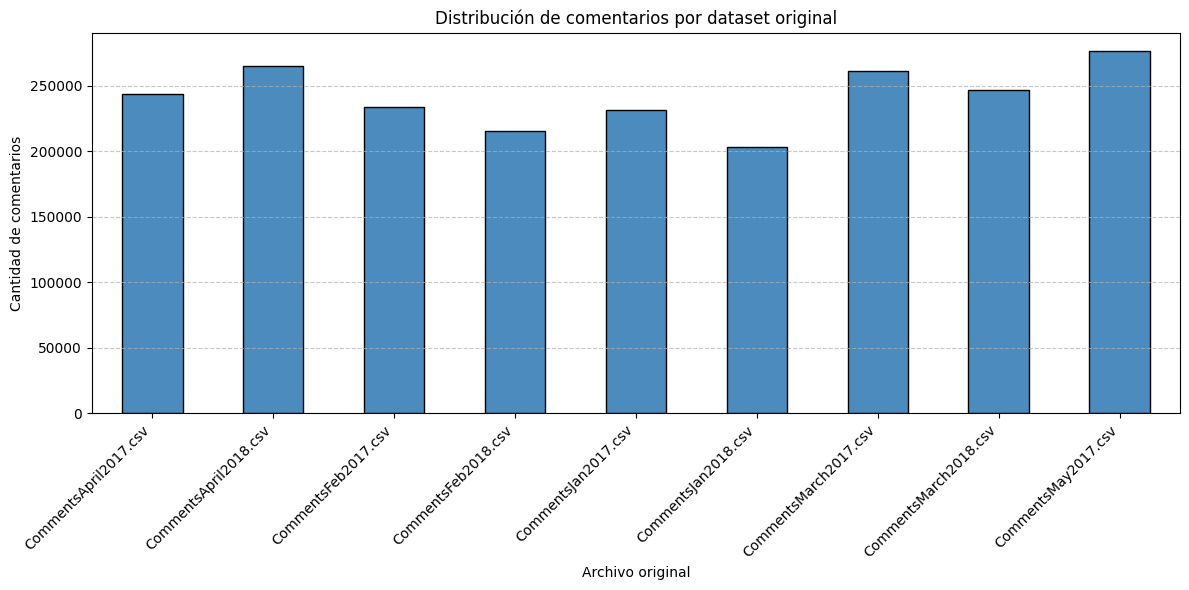

In [65]:
# Contar la cantidad de comentarios por dataset original
distribution = df["originalDataset"].value_counts().sort_index()

# Crear gráfico de barras
plt.figure(figsize=(12, 6))
distribution.plot(kind="bar", color="#4B8BBE", edgecolor="black")
plt.title("Distribución de comentarios por dataset original")
plt.xlabel("Archivo original")
plt.ylabel("Cantidad de comentarios")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostrar gráfico
plt.show()

La distribución es bastante homogenea, por lo que no se espera un existan problemas al momento de entrenar una red en base a las fuentes de los comentarios.

## 🔄 NLP: Preprocesamiento de Comentarios

Con el objetivo de preparar los comentarios para análisis de texto, se aplicó un proceso de limpieza y normalización sobre cada comentario (`commentBody`). Los pasos fueron los siguientes:

### ✨ Pasos del preprocesamiento

1. **Tokenización**  
   Se separó cada comentario en palabras (tokens) usando `word_tokenize` de NLTK.

2. **Conversión a minúsculas**  
   Todos los tokens fueron convertidos a minúsculas para reducir variaciones.

3. **Eliminación de puntuación**  
   Se descartaron todos los tokens que contenían símbolos no alfabéticos.

4. **Eliminación de Stopwords**  
   Se eliminaron las palabras comunes del idioma inglés (como *the*, *is*, *in*, etc.) utilizando la lista de `stopwords` de NLTK.

5. **Lematización**  
   Cada palabra fue reducida a su forma base (por ejemplo, *running* → *run*) con `WordNetLemmatizer`.

### 💾 Resultado

- Se creó una nueva columna en el dataset llamada `tokens`, que contiene la lista limpia de palabras por comentario.
- El nuevo dataset fue guardado como:  
  **`comments_with_tokens.csv`**

### 📦 Ejemplo del resultado:

| commentID | commentBody         | tokens                    |
|-----------|---------------------|---------------------------|
| 101       | This is amazing!!!  | ['amazing']              |
| 102       | I love this article | ['love', 'article']      |

In [67]:
# Inicializar herramientas
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
punctuations = set(string.punctuation)

def preprocess_text(text):
    try:
        # Tokenizar
        tokens = word_tokenize(str(text))
        # Convertir a minúsculas y eliminar puntuación
        tokens = [word.lower() for word in tokens if word.isalpha()]
        # Eliminar stopwords
        tokens = [word for word in tokens if word not in stop_words]
        # Lematizar
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        return tokens
    except:
        return []

# Aplicar la función a la columna de comentarios
df["tokens"] = df["commentBody"].apply(preprocess_text)

# Guardar el nuevo CSV
df.to_csv("comments_with_tokens.csv", index=False)

print("Archivo guardado como 'comments_with_tokens.csv' con columna 'tokens' incluida.")

Archivo guardado como 'comments_with_tokens.csv' con columna 'tokens' incluida.
